In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import math
from numba import jit, cuda
import itertools
from itertools import groupby
from gurobipy import Model, GRB, quicksum

In [2]:
df = pd.read_excel("salesCG201718.xls")
df = df.T.reset_index(drop=True).T
df = df.dropna()

In [3]:
coln = ['shop']
for i in range(1,21):
    coln.append("S"+str(i))
    coln.append("S"+str(i))  
    
row_df = pd.DataFrame([coln])
df = pd.concat([row_df, df], ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,shop,S1,S1,S2,S2,S3,S3,S4,S4,S5,...,S16,S16,S17,S17,S18,S18,S19,S19,S20,S20
1,daily sale,P1,P2,P1,P2,P1,P2,P1,P2,P1,...,P1,P2,P1,P2,P1,P2,P1,P2,P1,P2
2,2015-01-01 00:00:00,3,6,2,7,1,1,1,12,1,...,9,5,2,0,1,9,1,1,4,12
3,2015-01-02 00:00:00,2,3,1,8,4,3,4,9,4,...,5,9,2,11,2,1,1,10,1,12
4,2015-01-03 00:00:00,1,9,2,7,4,14,1,3,1,...,7,10,5,8,4,12,2,6,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2015-12-26 00:00:00,0,4,0,14,0,1,0,8,0,...,0,30,0,11,0,11,0,13,0,15
311,2015-12-28 00:00:00,0,5,0,7,0,9,0,2,0,...,0,12,0,2,0,13,0,5,0,18
312,2015-12-29 00:00:00,0,5,0,9,0,12,0,11,0,...,0,17,0,8,0,0,0,9,0,3
313,2015-12-30 00:00:00,0,5,0,5,0,8,0,17,0,...,0,32,0,0,0,7,0,5,0,11


In [4]:
df = df.set_index(0).T.groupby(["shop","daily sale"]).sum().T

In [5]:
df

shop       S1    S10     S11     S12     S13      ... S5     S6     S7     S8  \
daily sale P1 P2  P1  P2  P1  P2  P1  P2  P1  P2  ... P1  P2 P1  P2 P1  P2 P1   
2015-01-01  3  6   4  10   6  17   2   5   4  13  ...  1   2  3  10  4  11  3   
2015-01-02  2  3   0   8   3  16   6  19   3   9  ...  4   3  5   2  5  19  3   
2015-01-03  1  9   6   4   6   1   3  12   7  14  ...  1   4  3   5  1   7  5   
2015-01-05  3  8   3  18   6   8   5  18   4  20  ...  3   7  4  10  6   1  5   
2015-01-06  0  5   3   3   2  14   6   3   5  16  ...  3  11  1  12  1  22  3   
...        .. ..  ..  ..  ..  ..  ..  ..  ..  ..  ... ..  .. ..  .. ..  .. ..   
2015-12-26  0  4   0   1   0  21   0   3   0   3  ...  0  11  0  18  0  30  0   
2015-12-28  0  5   0  10   0  20   0  15   0  20  ...  0   3  0  11  0   5  0   
2015-12-29  0  5   0  15   0  27   0  10   0  25  ...  0   9  0  14  0   3  0   
2015-12-30  0  5   0  21   0   7   0  20   0   8  ...  0  10  0   6  0  12  0   
2015-12-31  0  3   0  23   0   4   0  22   0   3  ...  0   7  0   1  0  20  0   

shop           S9      
daily sale  P2 P1  P2  
2015-01-01   5  7  16  
2015-01-02   2  2  15  
2015-01-03   3  6  23  
2015-01-05  16  7   2  
2015-01-06   2  1  18  
...         .. ..  ..  
2015-12-26  29  0  18  
2015-12-28  13  0  22  
2015-12-29  10  0  19  
2015-12-30   7  0  20  
2015-12-31  18  0  35  

[313 rows x 40 columns]

In [6]:
coln = []
for i in range(1,21):
    coln.append("S"+str(i))
df = df[coln].reset_index()
df = df.rename(columns={'index':"date"})

In [7]:
df

shop             date S1    S2     S3     S4     S5  ... S16     S17     S18  \
daily sale            P1 P2 P1  P2 P1  P2 P1  P2 P1  ...  P1  P2  P1  P2  P1   
0          2015-01-01  3  6  2   7  1   1  1  12  1  ...   9   5   2   0   1   
1          2015-01-02  2  3  1   8  4   3  4   9  4  ...   5   9   2  11   2   
2          2015-01-03  1  9  2   7  4  14  1   3  1  ...   7  10   5   8   4   
3          2015-01-05  3  8  1   3  4   4  2  12  3  ...   8   7   6   6   3   
4          2015-01-06  0  5  2   6  0   5  2  13  3  ...   8   7   6   8   1   
..                ... .. .. ..  .. ..  .. ..  .. ..  ...  ..  ..  ..  ..  ..   
308        2015-12-26  0  4  0  14  0   1  0   8  0  ...   0  30   0  11   0   
309        2015-12-28  0  5  0   7  0   9  0   2  0  ...   0  12   0   2   0   
310        2015-12-29  0  5  0   9  0  12  0  11  0  ...   0  17   0   8   0   
311        2015-12-30  0  5  0   5  0   8  0  17  0  ...   0  32   0   0   0   
312        2015-12-31  0  3  0   1  0  12  0   1  0  ...   0   0   0  19   0   

shop           S19     S20      
daily sale  P2  P1  P2  P1  P2  
0            9   1   1   4  12  
1            1   1  10   1  12  
2           12   2   6   4   3  
3           15   4   1   0   0  
4           10   3   2   3   3  
..          ..  ..  ..  ..  ..  
308         11   0  13   0  15  
309         13   0   5   0  18  
310          0   0   9   0   3  
311          7   0   5   0  11  
312          0   0   5   0  18  

[313 rows x 41 columns]

In [8]:
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]

In [9]:
df_days_months = df.groupby([df['date'].dt.strftime('%B')]).mean().T[months]
df_days_months = df_days_months.apply(np.ceil)

In [10]:
df_loc = pd.read_excel("locations.xls")
df_loc

,Type,ID,x,y
0,Shop,1,2,6
1,Shop,2,10,6
2,Shop,3,3,5
3,Shop,4,5,5
4,Shop,5,8,5
5,Shop,6,0,4
6,Shop,7,2,3
7,Shop,8,6,3
8,Shop,9,10,3
9,Shop,10,12,3


In [11]:
def get_distance(t1,n1,t2,n2):
    df1 = df_loc[(df_loc["Type"]==t1)&(df_loc["ID"]==n1)]
    df2 = df_loc[(df_loc["Type"]==t2)&(df_loc["ID"]==n2)]
    distance = np.abs(df1.iloc[0].x - df2.iloc[0].x) + np.abs(df1.iloc[0].y - df2.iloc[0].y)
    return distance

In [12]:
def calculate_weight(p1,p2):
    return p1*.8 + p2*.4

In [13]:
df_days_months = df_days_months.reset_index()
for i in range(1,21):
    data1 = ['S'+str(i),'Total'] + calculate_weight(df_days_months.iloc[(i-1)*2][2:],df_days_months.iloc[(i-1)*2+1][2:]).tolist() 
    df_days_months.loc[-i] = data1

In [100]:
df_days_months = df_days_months.groupby(["shop","daily sale"]).sum().T[coln].T
df_days_months

date             January  February  March  April   May  June  July  August  \
shop daily sale                                                              
S1   P1              2.0       4.0    5.0    8.0   8.0   7.0   8.0     8.0   
     P2              7.0       4.0    2.0    1.0   0.0   0.0   0.0     2.0   
     Total           4.4       4.8    4.8    6.8   6.4   5.6   6.4     7.2   
S2   P1              2.0       4.0    5.0    7.0   9.0   6.0   7.0     8.0   
     P2              6.0       5.0    3.0    2.0   1.0   0.0   1.0     2.0   
     Total           4.0       5.2    5.2    6.4   7.6   4.8   6.0     7.2   
S3   P1              3.0       6.0    7.0   10.0  10.0   9.0  10.0     9.0   
     P2              7.0       5.0    4.0    2.0   1.0   0.0   1.0     2.0   
     Total           5.2       6.8    7.2    8.8   8.4   7.2   8.4     8.0   
S4   P1              3.0       5.0    8.0    8.0  11.0  10.0   9.0     8.0   
     P2              9.0       5.0    4.0    2.0   1.0   0.0   1.0     2.0   
     Total           6.0       6.0    8.0    7.2   9.2   8.0   7.6     7.2   
S5   P1              3.0       5.0    7.0    6.0   9.0   7.0   8.0     9.0   
     P2              6.0       5.0    3.0    2.0   1.0   0.0   1.0     2.0   
     Total           4.8       6.0    6.8    5.6   7.6   5.6   6.8     8.0   
S6   P1              3.0       7.0    6.0    8.0   8.0  10.0  13.0    10.0   
     P2              9.0       5.0    3.0    2.0   1.0   0.0   1.0     2.0   
     Total           6.0       7.6    6.0    7.2   6.8   8.0  10.8     8.8   
S7   P1              4.0       7.0   12.0   13.0  13.0  12.0  13.0    12.0   
     P2             14.0       6.0    5.0    3.0   1.0   0.0   1.0     2.0   
     Total           8.8       8.0   11.6   11.6  10.8   9.6  10.8    10.4   
S8   P1              4.0       7.0   10.0   14.0  22.0  15.0  15.0    14.0   
     P2             10.0       8.0    5.0    2.0   1.0   0.0   1.0     3.0   
     Total           7.2       8.8   10.0   12.0  18.0  12.0  12.4    12.4   
S9   P1              5.0       9.0   13.0   16.0  19.0  19.0  18.0    12.0   
     P2             13.0       7.0    6.0    3.0   1.0   0.0   1.0     3.0   
     Total           9.2      10.0   12.8   14.0  15.6  15.2  14.8    10.8   
S10  P1              4.0       6.0    7.0   11.0  15.0  12.0  13.0    10.0   
     P2             10.0       8.0    4.0    2.0   1.0   0.0   1.0     2.0   
     Total           7.2       8.0    7.2    9.6  12.4   9.6  10.8     8.8   
S11  P1              4.0       9.0   10.0   13.0  13.0  16.0  16.0    14.0   
     P2             11.0       7.0    4.0    3.0   1.0   0.0   1.0     3.0   
     Total           7.6      10.0    9.6   11.6  10.8  12.8  13.2    12.4   
S12  P1              5.0       7.0   11.0   11.0  17.0  14.0  15.0    16.0   
     P2             12.0       5.0    5.0    3.0   1.0   0.0   1.0     3.0   
     Total           8.8       7.6   10.8   10.0  14.0  11.2  12.4    14.0   
S13  P1              5.0       8.0   11.0   12.0  15.0  17.0  15.0    11.0   
     P2             14.0       8.0    5.0    2.0   1.0   0.0   1.0     3.0   
     Total           9.6       9.6   10.8   10.4  12.4  13.6  12.4    10.0   
S14  P1              5.0       8.0   10.0   16.0  16.0  16.0  19.0    12.0   
     P2             13.0       9.0    6.0    3.0   1.0   0.0   1.0     3.0   
     Total           9.2      10.0   10.4   14.0  13.2  12.8  15.6    10.8   
S15  P1              4.0       7.0   10.0   13.0  15.0  18.0  14.0    14.0   
     P2             12.0       8.0    6.0    3.0   1.0   0.0   1.0     2.0   
     Total           8.0       8.8   10.4   11.6  12.4  14.4  11.6    12.0   
S16  P1              7.0      12.0   15.0   19.0  19.0  18.0  20.0    20.0   
     P2             12.0      10.0    6.0    3.0   1.0   0.0   1.0     3.0   
     Total          10.4      13.6   14.4   16.4  15.6  14.4  16.4    17.2   
S17  P1              5.0       7.0    9.0   12.0  10.0  14.0  12.0    12.0   
     P2             11

In [15]:
dist_mat = []
for i in range(1,25):
    dist = []
    for j in range(1, 25):
        if i<=20:
            aa = "Shop"
        elif i<=22:
            aa = "Warehouse"
        else:
            aa = "Plant"
            
        if j<=20:
            bb = "Shop"
        elif j<=22:
            bb = "Warehouse"
        else:
            bb = "Plant"
            
        a = i
        b = j
        if a>=23:
            a-=22
        elif a>=21:
            a-=20
        if b>=23:
            b-=22
        elif b>=21:
            b-=20   
        dist.append(get_distance(aa,a,bb,b))
    dist_mat.append(dist)
                    
df_dist = pd.DataFrame(dist_mat)
df_dist     

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,8,2,4,7,4,3,7,11,13,...,11,13,6,8,11,16,5,11,3,9
1,8,0,8,6,3,12,11,7,3,5,...,7,5,14,12,9,8,9,5,11,9
2,2,8,0,2,5,4,3,5,9,11,...,9,11,6,6,9,14,3,9,3,7
3,4,6,2,0,3,6,5,3,7,9,...,7,9,8,6,7,12,3,7,5,5
4,7,3,5,3,0,9,8,4,4,6,...,4,6,11,9,6,9,6,4,8,6
5,4,12,4,6,9,0,3,7,11,13,...,11,13,6,8,11,16,5,11,1,9
6,3,11,3,5,8,3,0,4,8,10,...,8,10,3,5,8,13,2,8,2,6
7,7,7,5,3,4,7,4,0,4,6,...,4,6,7,5,4,9,2,4,6,2
8,11,3,9,7,4,11,8,4,0,2,...,4,2,11,9,6,5,6,2,10,6
9,13,5,11,9,6,13,10,6,2,0,...,6,4,13,11,8,3,8,4,12,8


In [16]:
n = 20
rnd = np.random
rnd.seed(0)

In [17]:
N = [i for i in range(0, 20)]
W = [20] + [21]
V = N + W 
A_W = [(i, j, w) for w in W for i in V for j in V if i != j] #all possible arcs

In [18]:
A_W

[(0, 1, 20),
 (0, 2, 20),
 (0, 3, 20),
 (0, 4, 20),
 (0, 5, 20),
 (0, 6, 20),
 (0, 7, 20),
 (0, 8, 20),
 (0, 9, 20),
 (0, 10, 20),
 (0, 11, 20),
 (0, 12, 20),
 (0, 13, 20),
 (0, 14, 20),
 (0, 15, 20),
 (0, 16, 20),
 (0, 17, 20),
 (0, 18, 20),
 (0, 19, 20),
 (0, 20, 20),
 (0, 21, 20),
 (1, 0, 20),
 (1, 2, 20),
 (1, 3, 20),
 (1, 4, 20),
 (1, 5, 20),
 (1, 6, 20),
 (1, 7, 20),
 (1, 8, 20),
 (1, 9, 20),
 (1, 10, 20),
 (1, 11, 20),
 (1, 12, 20),
 (1, 13, 20),
 (1, 14, 20),
 (1, 15, 20),
 (1, 16, 20),
 (1, 17, 20),
 (1, 18, 20),
 (1, 19, 20),
 (1, 20, 20),
 (1, 21, 20),
 (2, 0, 20),
 (2, 1, 20),
 (2, 3, 20),
 (2, 4, 20),
 (2, 5, 20),
 (2, 6, 20),
 (2, 7, 20),
 (2, 8, 20),
 (2, 9, 20),
 (2, 10, 20),
 (2, 11, 20),
 (2, 12, 20),
 (2, 13, 20),
 (2, 14, 20),
 (2, 15, 20),
 (2, 16, 20),
 (2, 17, 20),
 (2, 18, 20),
 (2, 19, 20),
 (2, 20, 20),
 (2, 21, 20),
 (3, 0, 20),
 (3, 1, 20),
 (3, 2, 20),
 (3, 4, 20),
 (3, 5, 20),
 (3, 6, 20),
 (3, 7, 20),
 (3, 8, 20),
 (3, 9, 20),
 (3, 10, 20),
 (3, 11, 20),


In [77]:
N = [i for i in range(0, 20)]
W = [20] + [21]
V = N + W 

A = [(i, j) for i in V for j in V if i != j] #all possible arcs
B = [(i, w) for i in N for w in W]
c = {(i, j): df_dist[i][j] for i, j in A} #costs of arcs
Q = 20 #capacity
q = {i: round(df_days_months[["January"]].T["S"+str(i+1)]["Total"][0],1) for i in N} #demand

In [20]:
c

{(0, 1): 8,
 (0, 2): 2,
 (0, 3): 4,
 (0, 4): 7,
 (0, 5): 4,
 (0, 6): 3,
 (0, 7): 7,
 (0, 8): 11,
 (0, 9): 13,
 (0, 10): 5,
 (0, 11): 6,
 (0, 12): 13,
 (0, 13): 6,
 (0, 14): 11,
 (0, 15): 13,
 (0, 16): 6,
 (0, 17): 8,
 (0, 18): 11,
 (0, 19): 16,
 (0, 20): 5,
 (0, 21): 11,
 (1, 0): 8,
 (1, 2): 8,
 (1, 3): 6,
 (1, 4): 3,
 (1, 5): 12,
 (1, 6): 11,
 (1, 7): 7,
 (1, 8): 3,
 (1, 9): 5,
 (1, 10): 13,
 (1, 11): 10,
 (1, 12): 5,
 (1, 13): 12,
 (1, 14): 7,
 (1, 15): 5,
 (1, 16): 14,
 (1, 17): 12,
 (1, 18): 9,
 (1, 19): 8,
 (1, 20): 9,
 (1, 21): 5,
 (2, 0): 2,
 (2, 1): 8,
 (2, 3): 2,
 (2, 4): 5,
 (2, 5): 4,
 (2, 6): 3,
 (2, 7): 5,
 (2, 8): 9,
 (2, 9): 11,
 (2, 10): 5,
 (2, 11): 4,
 (2, 12): 11,
 (2, 13): 4,
 (2, 14): 9,
 (2, 15): 11,
 (2, 16): 6,
 (2, 17): 6,
 (2, 18): 9,
 (2, 19): 14,
 (2, 20): 3,
 (2, 21): 9,
 (3, 0): 4,
 (3, 1): 6,
 (3, 2): 2,
 (3, 4): 3,
 (3, 5): 6,
 (3, 6): 5,
 (3, 7): 3,
 (3, 8): 7,
 (3, 9): 9,
 (3, 10): 7,
 (3, 11): 4,
 (3, 12): 9,
 (3, 13): 6,
 (3, 14): 7,
 (3, 15): 9,
 (3

In [21]:
q

{0: 4.4,
 1: 4.0,
 2: 5.2,
 3: 6.0,
 4: 4.8,
 5: 6.0,
 6: 8.8,
 7: 7.2,
 8: 9.2,
 9: 7.2,
 10: 7.6,
 11: 8.8,
 12: 9.6,
 13: 9.2,
 14: 8.0,
 15: 10.4,
 16: 8.4,
 17: 5.6,
 18: 4.4,
 19: 5.6}

In [23]:
mdl = Model('CVRP')

Set parameter GURO_PAR_SPECIAL
Set parameter TokenServer to value "TUELICENSE4"


In [24]:
x = mdl.addVars(A, vtype=GRB.BINARY)
y = mdl.addVars(B, vtype=GRB.BINARY)
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)

In [25]:
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A))

In [26]:
mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.addConstrs(quicksum(y[i, w] for w in [20,21]) == 1 for i in N)
mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])
               for i, j in A if i not in [20,21] and j not in [20,21])
mdl.addConstrs((x[20,j] == 1) >> (y[j,20] == 1) for j in N) 
mdl.addConstrs((x[20,j] == 1) >> (y[j,21] == 0) for j in N) 
mdl.addConstrs((x[21,j] == 1) >> (y[j,21] == 1) for j in N) 
mdl.addConstrs((x[21,j] == 1) >> (y[j,20] == 0) for j in N) 
mdl.addConstrs((x[i,j] == 1) >> (y[i,20] == y[j,20]) for i, j in A if i<20 and j<20)
mdl.addConstrs((x[i,j] == 1) >> (y[i,21] == y[j,21]) for i, j in A if i<20 and j<20)
mdl.addConstrs((y[i,20] == 1) >> (x[i,21] == 0) for i in N)
mdl.addConstrs((y[i,21] == 1) >> (x[i,20] == 0) for i in N)
# mdl.addConstrs(quicksum(x[i, j] for j in [20,21]) <= 1 for i in )
mdl.addConstrs(u[i] >= q[i] for i in N)
mdl.addConstrs(u[i] <= Q for i in N)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>}

In [27]:
#mdl.addConstrs(quicksum(x[i, j, w] for w in W for j in V if j != i) == 1 for i in N)
#mdl.addConstrs(quicksum(x[i, j, w] for w in W for i in V if i != j) == 1 for j in N)

#mdl.addConstrs((x[i, j, 20] == 1) >> (x[j, a, 21] == 0) #a route from warehouse 20 can not be continued by a shop that belongs to 21
#             for i,j,w in A_W for a in N if a != j) #it can continue to look for routes that belong to its own warehouse
#mdl.addConstrs((x[i, j, 21] == 1) >> (x[j, a, 20] == 0)
#               for i,j,w in A_W for a in N if a != j)

#mdl.addConstrs((x[i, j, w] == 1) >> (u[i]+q[j] == u[j]) #gurobi wants to create closed loops, if the capacity is exceeded, the only option it has is to go to a warehouse because there is 0 demand
#               for i, j, w in A_W if i not in W and j not in W)
#mdl.addConstrs(u[i] >= q[i] for i in N)
#mdl.addConstrs(u[i] <= Q for i in N)
    
#for i,j,w in A_W:
#    for a in N:
#        if a != j:
#            mdl.addGenConstrIndicator(x[i, j, 20], True, x[j, a, 21] == 0)
#            mdl.addGenConstrIndicator(x[i, j, 21], True, x[j, a, 20] == 0)


#mdl.addConstrs(sum(x[i,j,w]*q[i] for i in N for j in N if j!=i)*6 <= 650 for w in W) #warehouse constraint

#mdl.addConstrs(x[i, 20, 21] == 0 for i in N) #together with the >> constraints above, this makes sure that when starting in one warehousee it can not return to a different warehouse
#mdl.addConstrs(x[20 , j, 21] == 0 for j in N)
#mdl.addConstrs(x[i, 21, 20] == 0 for i in N)
#mdl.addConstrs(x[21 , j, 20] == 0 for j in N)

In [28]:
mdl.Params.MIPGap = 0.1
mdl.Params.TimeLimit = 10*60  # seconds
mdl.optimize()

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 100 rows, 522 columns and 920 nonzeros
Model fingerprint: 0x400c7175
Model has 1260 general constraints
Variable types: 20 continuous, 502 integer (502 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
  GenCon rhs range [1e+00, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1722 rows and 261 columns
Presolve time: 0.17s
Presolved: 1822 rows, 783 columns, 10056 nonzeros
Variable types: 113 continuous, 670 integer (480 binary)
Found heuristic solution: objective 224.0000000

Root relaxation: objective 5.175820e+01, 167 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

In [29]:
active_arcs = [a for a in A if x[a].x > 0.99]

In [30]:
active_arcs

[(0, 5),
 (1, 8),
 (2, 3),
 (3, 7),
 (4, 1),
 (5, 6),
 (6, 20),
 (7, 20),
 (8, 21),
 (9, 12),
 (10, 20),
 (11, 20),
 (12, 21),
 (13, 10),
 (14, 21),
 (15, 19),
 (16, 17),
 (17, 20),
 (18, 14),
 (19, 21),
 (20, 0),
 (20, 2),
 (20, 11),
 (20, 13),
 (20, 16),
 (21, 4),
 (21, 9),
 (21, 15),
 (21, 18)]

In [31]:
total_dist = 0

for i in active_arcs:
    total_dist += df_dist[i[0]][i[1]]
    
total_dist

84

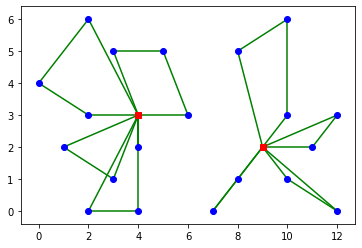

In [32]:
for i, j in active_arcs:
    plt.plot([df_loc.iloc[i].loc['x'], df_loc.iloc[j].loc['x']], [df_loc.iloc[i].loc['y'], df_loc.iloc[j].loc['y']], c='g', zorder=0)
plt.plot(df_loc.iloc[20].loc['x'], df_loc.iloc[20].loc['y'], c='r', marker='s')
plt.plot(df_loc.iloc[21].loc['x'], df_loc.iloc[21].loc['y'], c='r', marker='s')

plt.scatter(df_loc.iloc[:20][['x']], df_loc.iloc[:20][['y']], c='b')

In [33]:
active_arcs[1]

(1, 8)

In [34]:
y

{(0, 20): <gurobi.Var C462 (value 1.0)>,
 (0, 21): <gurobi.Var C463 (value 0.0)>,
 (1, 20): <gurobi.Var C464 (value 0.0)>,
 (1, 21): <gurobi.Var C465 (value 1.0)>,
 (2, 20): <gurobi.Var C466 (value 1.0)>,
 (2, 21): <gurobi.Var C467 (value 0.0)>,
 (3, 20): <gurobi.Var C468 (value 1.0)>,
 (3, 21): <gurobi.Var C469 (value 0.0)>,
 (4, 20): <gurobi.Var C470 (value 0.0)>,
 (4, 21): <gurobi.Var C471 (value 1.0)>,
 (5, 20): <gurobi.Var C472 (value 1.0)>,
 (5, 21): <gurobi.Var C473 (value 0.0)>,
 (6, 20): <gurobi.Var C474 (value 1.0)>,
 (6, 21): <gurobi.Var C475 (value 0.0)>,
 (7, 20): <gurobi.Var C476 (value 1.0)>,
 (7, 21): <gurobi.Var C477 (value 0.0)>,
 (8, 20): <gurobi.Var C478 (value 0.0)>,
 (8, 21): <gurobi.Var C479 (value 1.0)>,
 (9, 20): <gurobi.Var C480 (value 0.0)>,
 (9, 21): <gurobi.Var C481 (value 1.0)>,
 (10, 20): <gurobi.Var C482 (value 1.0)>,
 (10, 21): <gurobi.Var C483 (value 0.0)>,
 (11, 20): <gurobi.Var C484 (value 1.0)>,
 (11, 21): <gurobi.Var C485 (value 0.0)>,
 (12, 20): <

In [35]:
print(y.select(2, 21))

[<gurobi.Var C467 (value 0.0)>]


In [36]:
used_y = [b for b in B if y[b].x > 0.99]
used_y

[(0, 20),
 (1, 21),
 (2, 20),
 (3, 20),
 (4, 21),
 (5, 20),
 (6, 20),
 (7, 20),
 (8, 21),
 (9, 21),
 (10, 20),
 (11, 20),
 (12, 21),
 (13, 20),
 (14, 21),
 (15, 21),
 (16, 20),
 (17, 20),
 (18, 21),
 (19, 21)]

In [37]:
res = dict()
  
# forming equal groups
for key, val in groupby(sorted(used_y, key = lambda ele: ele[1]), key = lambda ele: ele[1]):
    res[key] = [ele[0] for ele in val] 

In [38]:
res[20]

[0, 2, 3, 5, 6, 7, 10, 11, 13, 16, 17]

In [39]:
# printing results
print(str(res))

{20: [0, 2, 3, 5, 6, 7, 10, 11, 13, 16, 17], 21: [1, 4, 8, 9, 12, 14, 15, 18, 19]}


In [40]:
df_days_months

shop         S1              S2               S3                S4  ...   S17  \
daily sale   P1   P2 Total   P1   P2 Total    P1    P2 Total    P1  ... Total   
date                                                                ...         
January     2.0  7.0   4.4  2.0  6.0   4.0   3.0   7.0   5.2   3.0  ...   8.4   
February    4.0  4.0   4.8  4.0  5.0   5.2   6.0   5.0   6.8   5.0  ...   8.0   
March       5.0  2.0   4.8  5.0  3.0   5.2   7.0   4.0   7.2   8.0  ...   8.8   
April       8.0  1.0   6.8  7.0  2.0   6.4  10.0   2.0   8.8   8.0  ...  10.4   
May         8.0  0.0   6.4  9.0  1.0   7.6  10.0   1.0   8.4  11.0  ...   8.4   
June        7.0  0.0   5.6  6.0  0.0   4.8   9.0   0.0   7.2  10.0  ...  11.2   
July        8.0  0.0   6.4  7.0  1.0   6.0  10.0   1.0   8.4   9.0  ...  10.0   
August      8.0  2.0   7.2  8.0  2.0   7.2   9.0   2.0   8.0   8.0  ...  10.4   
September   6.0  2.0   5.6  5.0  3.0   5.2   8.0   3.0   7.6   7.0  ...   7.6   
October     5.0  4.0   5.6  5.0  4.0   5.6   6.0   6.0   7.2   6.0  ...   7.6   
November    2.0  5.0   3.6  2.0  6.0   4.0   3.0   8.0   5.6   3.0  ...   7.2   
December    0.0  7.0   2.8  0.0  9.0   3.6   0.0  11.0   4.4   0.0  ...   5.6   

shop         S18             S19              S20              
daily sale    P1   P2 Total   P1   P2 Total    P1    P2 Total  
date                                                           
January      3.0  8.0   5.6  2.0  7.0   4.4   3.0   8.0   5.6  
February     5.0  5.0   6.0  5.0  4.0   5.6   4.0   5.0   5.2  
March        8.0  3.0   7.6  6.0  3.0   6.0   9.0   3.0   8.4  
April       11.0  2.0   9.6  6.0  2.0   5.6  10.0   2.0   8.8  
May          9.0  1.0   7.6  8.0  0.0   6.4  11.0   1.0   9.2  
June        10.0  0.0   8.0  8.0  0.0   6.4   9.0   0.0   7.2  
July        10.0  1.0   8.4  6.0  0.0   4.8  10.0   1.0   8.4  
August       9.0  1.0   7.6  6.0  1.0   5.2  10.0   2.0   8.8  
September    7.0  3.0   6.8  5.0  3.0   5.2   9.0   3.0   8.4  
October      5.0  5.0   6.0  4.0  4.0   4.8   6.0   5.0   6.8  
November     3.0  9.0   6.0  2.0  7.0   4.4   2.0   7.0   4.4  
December     0.0  8.0   3.2  0.0  8.0   3.2   0.0  11.0   4.4  

[12 rows x 60 columns]

In [60]:
daily_products_per_month = df_days_months.T[['January']]

# Warehouse stocking

In [61]:
daily_products_per_month

date             January
shop daily sale         
S1   P1              2.0
     P2              7.0
     Total           4.4
S2   P1              2.0
     P2              6.0
     Total           4.0
S3   P1              3.0
     P2              7.0
     Total           5.2
S4   P1              3.0
     P2              9.0
     Total           6.0
S5   P1              3.0
     P2              6.0
     Total           4.8
S6   P1              3.0
     P2              9.0
     Total           6.0
S7   P1              4.0
     P2             14.0
     Total           8.8
S8   P1              4.0
     P2             10.0
     Total           7.2
S9   P1              5.0
     P2             13.0
     Total           9.2
S10  P1              4.0
     P2             10.0
     Total           7.2
S11  P1              4.0
     P2             11.0
     Total           7.6
S12  P1              5.0
     P2             12.0
     Total           8.8
S13  P1              5.0
     P2             14.0
     Total           9.6
S14  P1              5.0
     P2             13.0
     Total           9.2
S15  P1              4.0
     P2             12.0
     Total           8.0
S16  P1              7.0
     P2             12.0
     Total          10.4
S17  P1              5.0
     P2             11.0
     Total           8.4
S18  P1              3.0
     P2              8.0
     Total           5.6
S19  P1              2.0
     P2              7.0
     Total           4.4
S20  P1              3.0
     P2              8.0
     Total           5.6

In [62]:
P1_w1 = 0
P2_w1 = 0

for i in res[20]:
    P1_w1 += int(daily_products_per_month.T[('S'+str(i+1), 'P1')])
    P2_w1 += int(daily_products_per_month.T[('S'+str(i+1), 'P2')])
    
weekly_P1_w1 = P1_w1*6
weekly_P2_w1 = P2_w1*6

In [63]:
P1_w2 = 0
P2_w2 = 0

for i in res[21]:
    P1_w2 += int(daily_products_per_month.T[('S'+str(i+1), 'P1')])
    P2_w2 += int(daily_products_per_month.T[('S'+str(i+1), 'P2')])
    
weekly_P1_w2 = P1_w2*6
weekly_P2_w2 = P2_w2*6

In [64]:
print(weekly_P1_w1, weekly_P2_w1, weekly_P1_w2, weekly_P2_w2)

246 666 210 528


In [70]:
weekly_trucks_w1 = math.ceil((weekly_P1_w1*.8 + weekly_P2_w1*.4)/ 20)
weekly_trucks_w2 = math.ceil((weekly_P1_w2*.8 + weekly_P2_w2*.4) / 20)
print(weekly_trucks_w1, weekly_trucks_w2)

24 19


In [71]:
weekly_P2_w1*.4

266.40000000000003

In [72]:
weekly_warehouse_supply_cost = weekly_trucks_w1*2*df_dist[20][22] + weekly_trucks_w2*2*df_dist[21][23] #w1 weekly supply + w2 weekly supply
weekly_warehouse_supply_cost

344

In [73]:
monthly_costs = weekly_warehouse_supply_cost*4 + total_dist*6*4

In [74]:
monthly_costs

3392

In [109]:
df_days_months = df_days_months.groupby(["shop","daily sale"]).sum().T[coln].T
for m in months:
    daily_products_per_month = df_days_months[[m]]
    print(daily_products_per_month)

date             January
shop daily sale         
S1   P1              2.0
     P2              7.0
     Total           4.4
S2   P1              2.0
     P2              6.0
     Total           4.0
S3   P1              3.0
     P2              7.0
     Total           5.2
S4   P1              3.0
     P2              9.0
     Total           6.0
S5   P1              3.0
     P2              6.0
     Total           4.8
S6   P1              3.0
     P2              9.0
     Total           6.0
S7   P1              4.0
     P2             14.0
     Total           8.8
S8   P1              4.0
     P2             10.0
     Total           7.2
S9   P1              5.0
     P2             13.0
     Total           9.2
S10  P1              4.0
     P2             10.0
     Total           7.2
S11  P1              4.0
     P2             11.0
     Total           7.6
S12  P1              5.0
     P2             12.0
     Total           8.8
S13  P1              5.0
     P2             14.0


Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 60
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 100 rows, 522 columns and 920 nonzeros
Model fingerprint: 0x400c7175
Model has 1260 general constraints
Variable types: 20 continuous, 502 integer (502 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
  GenCon rhs range [1e+00, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1722 rows and 261 columns
Presolve time: 0.15s
Presolved: 1822 rows, 783 columns, 10056 nonzeros
Variable types: 113 continuous, 670 integer (480 binary)
Found heuristic solution: objective 224.0000000

Root relaxation: objective 5.175820e+01, 167 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

     0     0   68.00000    0  163   92.00000   68.00000  26.1%     -    1s
     0     0   68.00000    0  169   92.00000   68.00000  26.1%     -    1s
H    0     0                      90.0000000   68.00000  24.4%     -    1s
     0     0   68.87401    0  203   90.00000   68.87401  23.5%     -    1s
     0     0   69.00549    0  198   90.00000   69.00549  23.3%     -    1s
     0     0   69.11559    0  208   90.00000   69.11559  23.2%     -    1s
     0     0   69.20878    0  208   90.00000   69.20878  23.1%     -    1s
     0     0   69.21716    0  205   90.00000   69.21716  23.1%     -    1s
     0     0   69.21716    0  205   90.00000   69.21716  23.1%     -    1s
     0     0   69.35386    0  228   90.00000   69.35386  22.9%     -    1s
     0     0   69.38251    0  231   90.00000   69.38251  22.9%     -    1s
H    0     0                      88.0000000   69.38704  21.2%     -    1s
     0     0   69.38704    0  239   88.00000   69.38704  21.2%     -    1s
     0     0   69.39804  

H    0     0                     120.0000000   77.02608  35.8%     -    0s
     0     0   77.02608    0  142  120.00000   77.02608  35.8%     -    0s
     0     0   77.96902    0  141  120.00000   77.96902  35.0%     -    0s
     0     0   77.96902    0  141  120.00000   77.96902  35.0%     -    0s
H    0     0                     112.0000000   77.96902  30.4%     -    0s
     0     0   84.64957    0  173  112.00000   84.64957  24.4%     -    0s
     0     0   86.97293    0  162  112.00000   86.97293  22.3%     -    0s
     0     0   87.44743    0  166  112.00000   87.44743  21.9%     -    0s
H    0     0                     108.0000000   87.48037  19.0%     -    0s
     0     0   87.48037    0  167  108.00000   87.48037  19.0%     -    0s
H    0     0                      98.0000000   87.48037  10.7%     -    0s
H    0     0                      96.0000000   87.48037  8.87%     -    0s

Cutting planes:
  Learned: 3
  Cover: 8
  Implied bound: 14
  MIR: 52
  StrongCG: 6
  GUB cover: 9


H    0     0                     102.0000000   89.26252  12.5%     -    0s
     0     0   89.29912    0  107  102.00000   89.29912  12.5%     -    0s
     0     0   89.29954    0  110  102.00000   89.29954  12.5%     -    0s
     0     0   91.25761    0  120  102.00000   91.25761  10.5%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 20
  Cover: 6
  Implied bound: 8
  Clique: 2
  MIR: 26
  StrongCG: 8
  GUB cover: 11
  Zero half: 3
  RLT: 8
  Relax-and-lift: 9

Explored 1 nodes (422 simplex iterations) in 0.35 seconds (0.09 work units)
Thread count was 12 (of 12 available processors)

Solution count 5: 102 118 120 ... 204

Optimal solution found (tolerance 1.00e-01)
Best objective 1.020000000000e+02, best bound 9.200000000000e+01, gap 9.8039%
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 60
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 100 rows, 522 colu

H    0     0                      92.0000000   60.00000  34.8%     -    0s
     0     0   62.99756    0  205   92.00000   62.99756  31.5%     -    0s
     0     0   63.91569    0  208   92.00000   63.91569  30.5%     -    0s
     0     0   64.12393    0  214   92.00000   64.12393  30.3%     -    0s
     0     0   64.16526    0  217   92.00000   64.16526  30.3%     -    0s
     0     0   64.16795    0  219   92.00000   64.16795  30.3%     -    0s
     0     0   64.16795    0  219   92.00000   64.16795  30.3%     -    0s
H    0     0                      90.0000000   64.16795  28.7%     -    0s
     0     0   68.06481    0  235   90.00000   68.06481  24.4%     -    1s
     0     0   68.14781    0  199   90.00000   68.14781  24.3%     -    1s
     0     0   68.15846    0  199   90.00000   68.15846  24.3%     -    1s
     0     0   68.15864    0  210   90.00000   68.15864  24.3%     -    1s
     0     0   70.56566    0  165   90.00000   70.56566  21.6%     -    1s
     0     0   70.60264  

  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
  GenCon rhs range [1e+00, 8e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1758 rows and 277 columns
Presolve time: 0.15s
Presolved: 1858 rows, 799 columns, 10210 nonzeros
Variable types: 129 continuous, 670 integer (480 binary)
Found heuristic solution: objective 224.0000000

Root relaxation: objective 5.048000e+01, 124 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   50.48000    0   46  224.00000   50.48000  77.5%     -    0s
H    0     0                     184.0000000   50.48000  72.6%     -    0s
H    0     0                      80.0000000   50.48000  36.9%     -    0s
     0     0   51.00000    0   81   80.00000   51.00000  36.3%     -    0s
H    0     0                      78.0000000   51.00000  34.6%     -    

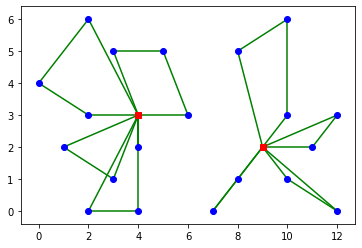

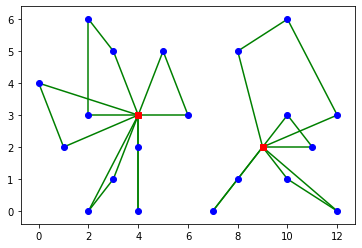

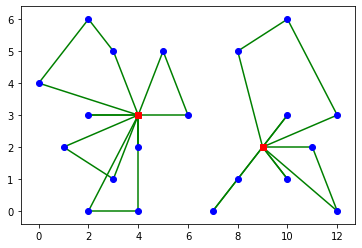

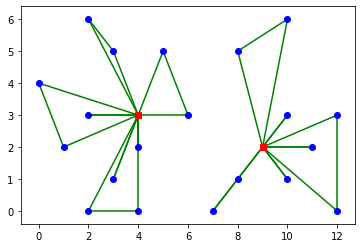

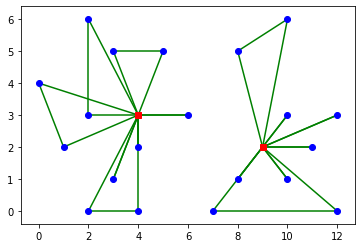

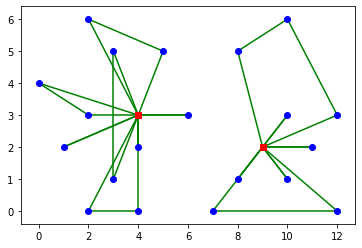

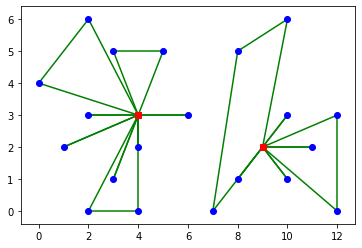

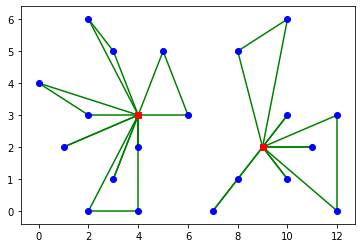

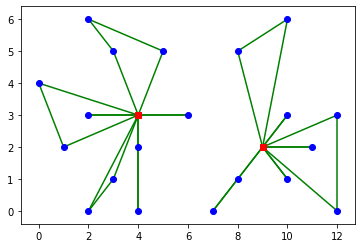

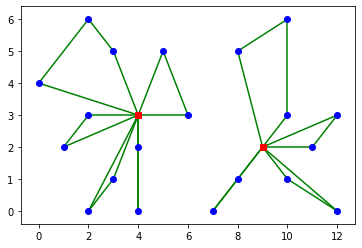

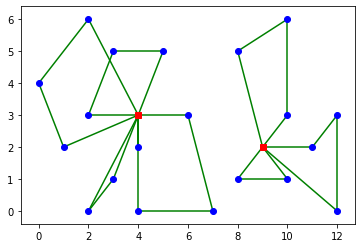

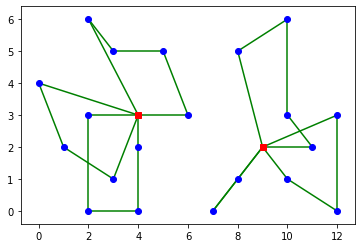

In [114]:
monthly_costs = pd.DataFrame(index=['Costs'], columns=months)
df_days_months = df_days_months.groupby(["shop","daily sale"]).sum().T[coln].T

for m in months:
    N = [i for i in range(0, 20)]
    W = [20] + [21]
    V = N + W 

    A = [(i, j) for i in V for j in V if i != j] #all possible arcs
    B = [(i, w) for i in N for w in W]
    c = {(i, j): df_dist[i][j] for i, j in A} #costs of arcs
    Q = 20 #capacity
    q = {i: round(df_days_months[[m]].T["S"+str(i+1)]["Total"][0],1) for i in N} #demand
    
    mdl = Model('CVRP')
    x = mdl.addVars(A, vtype=GRB.BINARY)
    y = mdl.addVars(B, vtype=GRB.BINARY)
    u = mdl.addVars(N, vtype=GRB.CONTINUOUS)
    
    mdl.modelSense = GRB.MINIMIZE
    mdl.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A))
    
    mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
    mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
    mdl.addConstrs(quicksum(y[i, w] for w in [20,21]) == 1 for i in N)
    mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])
               for i, j in A if i not in [20,21] and j not in [20,21])
    mdl.addConstrs((x[20,j] == 1) >> (y[j,20] == 1) for j in N) 
    mdl.addConstrs((x[20,j] == 1) >> (y[j,21] == 0) for j in N) 
    mdl.addConstrs((x[21,j] == 1) >> (y[j,21] == 1) for j in N) 
    mdl.addConstrs((x[21,j] == 1) >> (y[j,20] == 0) for j in N) 
    mdl.addConstrs((x[i,j] == 1) >> (y[i,20] == y[j,20]) for i, j in A if i<20 and j<20)
    mdl.addConstrs((x[i,j] == 1) >> (y[i,21] == y[j,21]) for i, j in A if i<20 and j<20)
    mdl.addConstrs((y[i,20] == 1) >> (x[i,21] == 0) for i in N)
    mdl.addConstrs((y[i,21] == 1) >> (x[i,20] == 0) for i in N)
    # mdl.addConstrs(quicksum(x[i, j] for j in [20,21]) <= 1 for i in )
    mdl.addConstrs(u[i] >= q[i] for i in N)
    mdl.addConstrs(u[i] <= Q for i in N)
    
    mdl.Params.MIPGap = 0.1
    mdl.Params.TimeLimit = 1*60  # seconds
    mdl.optimize()
    
    active_arcs = [a for a in A if x[a].x > 0.99]
    
    total_dist = 0
    for i in active_arcs:
        total_dist += df_dist[i[0]][i[1]]
    
    plt.figure()
    for i, j in active_arcs:
        plt.plot([df_loc.iloc[i].loc['x'], df_loc.iloc[j].loc['x']], [df_loc.iloc[i].loc['y'], df_loc.iloc[j].loc['y']], c='g', zorder=0)
    plt.plot(df_loc.iloc[20].loc['x'], df_loc.iloc[20].loc['y'], c='r', marker='s')
    plt.plot(df_loc.iloc[21].loc['x'], df_loc.iloc[21].loc['y'], c='r', marker='s')
    plt.scatter(df_loc.iloc[:20][['x']], df_loc.iloc[:20][['y']], c='b')
    
    used_y = [b for b in B if y[b].x > 0.99]
    
    res = dict()
    for key, val in groupby(sorted(used_y, key = lambda ele: ele[1]), key = lambda ele: ele[1]):
        res[key] = [ele[0] for ele in val]
        
    daily_products_per_month = df_days_months[[m]]
    
    P1_w1 = 0
    P2_w1 = 0
    for i in res[20]:
        P1_w1 += int(daily_products_per_month.T[('S'+str(i+1), 'P1')])
        P2_w1 += int(daily_products_per_month.T[('S'+str(i+1), 'P2')])
    weekly_P1_w1 = P1_w1*6
    weekly_P2_w1 = P2_w1*6
    
    P1_w2 = 0
    P2_w2 = 0
    for i in res[21]:
        P1_w2 += int(daily_products_per_month.T[('S'+str(i+1), 'P1')])
        P2_w2 += int(daily_products_per_month.T[('S'+str(i+1), 'P2')])
    weekly_P1_w2 = P1_w2*6
    weekly_P2_w2 = P2_w2*6
    
    
    weekly_trucks_w1 = math.ceil((weekly_P1_w1*.8 + weekly_P2_w1*.4) / 20)
    weekly_trucks_w2 = math.ceil((weekly_P1_w2*.8 + weekly_P2_w2*.4) / 20)
    
    weekly_warehouse_supply_cost = weekly_trucks_w1*2*df_dist[20][22] + weekly_trucks_w2*2*df_dist[21][23]
    
    
    monthly_costs[m]['Costs'] = weekly_warehouse_supply_cost*4 + total_dist*6*4

In [96]:
monthly_costs = pd.DataFrame(index=['Costs'], columns=months)
for m in months:
    monthly_costs[m]['costs'] = 2

In [118]:
monthly_costs.T

,Costs
January,3392
February,3600
March,3888
April,4224
May,4528
June,4368
July,4464
August,4272
September,3968
October,3584


In [116]:
cool = pd.read_excel('monthly_revenue.xlsx', header=None)
cool[0][0] = 'month'
cool.columns = cool.iloc[0]
cool.drop(0).set_index('month')

,Revenue
month,
January,1053600
February,1142400
March,1504800
April,1766400
May,1934400
June,1879200
July,1972800
August,1776000
September,1555200
